In [1]:
import numpy as np
import fenics


class FenicsRegularGridInterpolator2D: 
    # https://github.com/NickAlger/helper_functions/blob/master/interpolate_fenics_function_onto_regular_grid.ipynb
    def __init__(me, function_space_V, grid_oversampling_parameter=2.0):
        me.V = function_space_V
        me.mesh = me.V.mesh()
        me.eta = grid_oversampling_parameter

        me.X = V.tabulate_dof_coordinates()
        me.min_point = np.min(me.X, axis=0)
        me.max_point = np.max(me.X, axis=0)
        
        me.nn = (me.eta * (me.max_point - me.min_point) / me.mesh.hmin()).astype(int)
        me.bounding_box_mesh = fenics.RectangleMesh(fenics.Point(me.min_point), 
                                                    fenics.Point(me.max_point), 
                                                    me.nn[0], me.nn[1])
        
        me.V_grid = fenics.FunctionSpace(me.bounding_box_mesh, 'CG', 1)
        me.X_grid = me.V_grid.tabulate_dof_coordinates()
        
        me.sort_inds = np.lexsort(me.X_grid.T)
        
        me.xx = np.linspace(me.min_point[0], me.max_point[0], me.nn[0]+1)
        me.yy = np.linspace(me.min_point[1], me.max_point[1], me.nn[1]+1)
        
    def interpolate_function(me, u):
        u.set_allow_extrapolation(True)
        u_grid = fenics.interpolate(u, me.V_grid)
        U = u_grid.vector()[me.sort_inds].reshape(me.nn+1)
        return U

## Test/Example usage

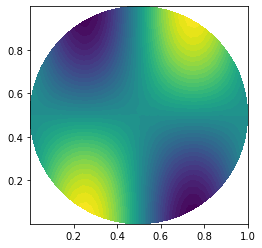

In [2]:
import mshr
import matplotlib.pyplot as plt

def circle_mesh(center, radius, resolution):
    outer_circle = mshr.Circle(fenics.Point(center[0], center[1]), radius)
    mesh = mshr.generate_mesh(outer_circle, resolution)
    return mesh

mesh_center = np.array([0.5,0.5])
mesh_radius = 0.5
mesh_h= 5e-2
finite_element_order=2

mesh = circle_mesh(mesh_center, mesh_radius, 1./mesh_h)
V = fenics.FunctionSpace(mesh, 'CG', finite_element_order)

u = fenics.interpolate(fenics.Expression('sin(2*pi*x[0])*cos(1*pi*x[1])', domain=mesh, degree=5), V)
fenics.plot(u)

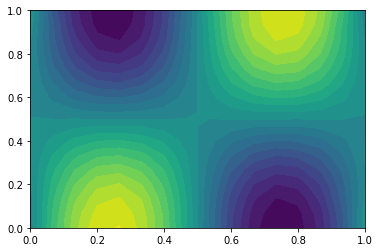

In [13]:
FRGI = FenicsRegularGridInterpolator2D(V)
U = FRGI.interpolate_function(u)

Xg, Yg = np.meshgrid(FRGI.xx, FRGI.yy, indexing='xy')
plt.contourf(Xg,Yg,U, levels=20)

## Explanation/walkthrough

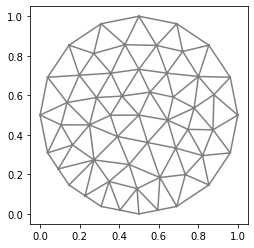

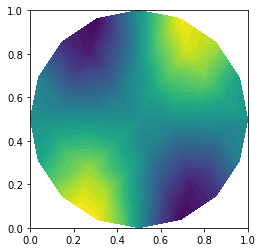

In [4]:
mesh_center = np.array([0.5,0.5])
mesh_radius = 0.5
mesh_h= 2e-1
finite_element_order=2

mesh = circle_mesh(mesh_center, mesh_radius, 1./mesh_h)
fenics.plot(mesh)

V = fenics.FunctionSpace(mesh, 'CG', finite_element_order)
u = fenics.interpolate(fenics.Expression('sin(2*pi*x[0])*cos(1*pi*x[1])', domain=mesh, degree=5), V)
plt.figure()
fenics.plot(u)

### Make a regular grid mesh just barely covering the original mesh

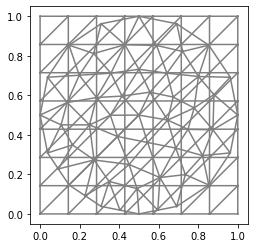

In [6]:
grid_oversampling_parameter = 1.0
X = V.tabulate_dof_coordinates()
min_point = np.min(X, axis=0)
max_point = np.max(X, axis=0)
nn = (grid_oversampling_parameter * (max_point - min_point) / mesh.hmin()).astype(int)
bounding_box_mesh = fenics.RectangleMesh(fenics.Point(min_point), fenics.Point(max_point), nn[0], nn[1])

fenics.plot(bounding_box_mesh)
fenics.plot(mesh)

### We can interpolate from irregular grid to regular grid with fenics.interpolate()

Text(0.5, 1.0, 'u_grid')

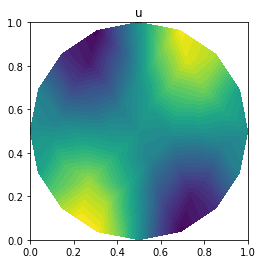

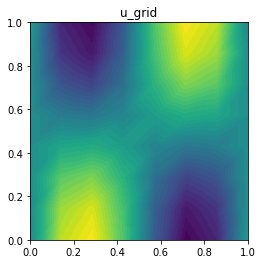

In [7]:
V_grid = fenics.FunctionSpace(bounding_box_mesh, 'CG', 1)
X_grid = V_grid.tabulate_dof_coordinates()

u.set_allow_extrapolation(True)
u_grid = fenics.interpolate(u, V_grid)

fenics.plot(u)
plt.title('u')
plt.figure()
fenics.plot(u_grid)
plt.title('u_grid')

### Problem: Fenics does not place degree of freedom locations in lexographic order. 
### Solution: use numpy.lexsort to find the lexographic sort order 

Text(0.5, 1.0, 'grid dof locations lexographically sorted')

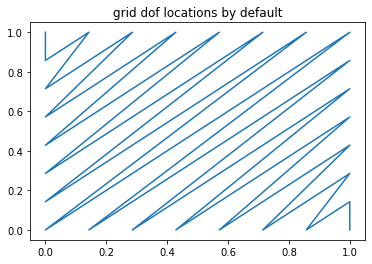

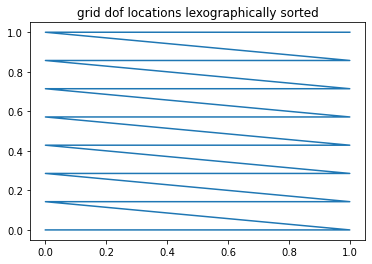

In [8]:
sort_inds = np.lexsort(X_grid.T)
sorted_X_grid = X_grid[sort_inds, :]

plt.plot(X_grid[:,0], X_grid[:,1])
plt.title('grid dof locations by default')
plt.figure()
plt.plot(sorted_X_grid[:,0], sorted_X_grid[:,1])
plt.title('grid dof locations lexographically sorted')

### Interpolation steps:
 1. Interpolate to regular grid
 2. lexographically order resulting function vector
 3. Reshape vector to box of numbers

Text(0.5, 1.0, 'U')

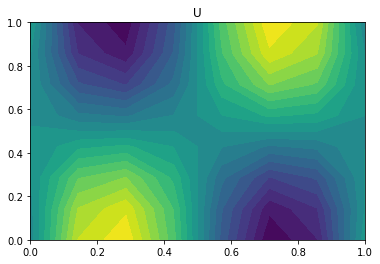

In [15]:
U = u_grid.vector()[sort_inds].reshape(nn+1)

xx = np.linspace(min_point[0], max_point[0], nn[0]+1)
yy = np.linspace(min_point[1], max_point[1], nn[1]+1)
Xg, Yg = np.meshgrid(xx, yy, indexing='xy')

plt.contourf(Xg, Yg, U, levels=20)
plt.title('U')

### If we didn't lexographically reorder, we get junk

Text(0.5, 1.0, 'U_unsorted')

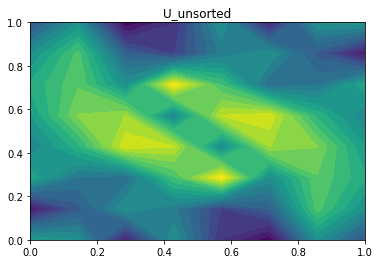

In [16]:
U_unsorted = u_grid.vector()[:].reshape(nn+1)

plt.contourf(Xg, Yg, U_unsorted, levels=20)
plt.title('U_unsorted')